# The Exploration of Solar Storms at NASA FDL

## Nicolle Eagan, Kx25

## 1. Database Creation

The data can be found at https://geomag.usgs.gov/products/. The results presented in this notebook rely on data collected at magnetic observatories operated by the U.S. Geological Survey (USGS, geomag.usgs.gov). The data was taken from 14 USGS observatories across the US, and can be scraped from the geomag website via Python scripts located at https://github.com/usgs/geomag-algorithms. This part is intensive so it has been omitted from the notebook. Then, one needs to transform the resulting pickle files to CSV files so that it can be read into q. This was done by running a script provided by George Gerules, an FDL 2017 participant. The following is example code in q for loading in a CSV file and transforming it to a kdb+ table. I chose to make a database of the year 2016, which was the year the FlareNet team used for their validation set. 

In [1]:
/Create list of column headers.
c:`BOU`BRW`BSL`CMO`DED`FRD`FRN`GUA`HON`NEW`SHU`SIT`SJG`TUC

In [2]:
/Read CSV file into kdb table. Give schema of all reals and add headers to table.
\cd /data/csvs
x2016mins:flip c!(14#"E";",")0:`X_2016_minutes.csv
10#x2016mins

BOU      BRW      BSL      CMO      DED      FRD      FRN      GUA      HON  ..
-----------------------------------------------------------------------------..
20484.48 8185.758 23137.91 11004.66 8459.338 21172.83 22524.16 35133.57 26752..
20483.33 8189.501 23139.86 11006.38 8462.341 21177.18 22522.63 35133.68 26752..
20483.49 8193.536 23142.37 10995.67 8464.749 21180.09 22521.65 35133.7  26752..
20484.36 8195.826 23144.82 10994.46 8466.066 21181.83 22520.73 35133.48 26751..
20485.51 8196.505 23146.62 10996.82 8465.778 21182.34 22520.38 35133.89 26751..
20486.94 8197.31  23148.08 10999.73 8465.389 21182.49 22520.05 35134.09 26751..
20489.18 8199.668 23149.29 10985.16 8466.902 21182.16 22520.06 35133.93 26750..
20490.8  8200.056 23151.04 10967.49 8464.998 21182.53 22520.84 35133.63 26750..
20492.22 8200.869 23152.01 10953.54 8464.279 21181.12 22521.71 35133.96 26750..
20492.43 8200.518 23152.65 10947.82 8462.999 21179.38 22521.22 35134.46 26750..


In [3]:
/Create list of all dates in 2016.
range2016:2016.01.01+til 366

/Create list of all minutes in a day.
times:00:00+til 1440

/Create 2D list - each day mapped to each minute. Add data and minute together to get full timestamp.
fullTimes2016:raze {x,'times}'[range2016]
ts2016:(first'[fullTimes2016])+last'[fullTimes2016]

In [4]:
/Creating sym (center) column. Need count to be 7,378,560 as that will be total count of table.
n:7378560
readings2016:n#raze flip {x,'x}/[20;c]

In [5]:
/Creating time column.
x2016mins:`ts xcols update ts:ts2016 from x2016mins

In [6]:
/Creating list of all times for final table.
allts2016:asc n#{x,x}/[{7378560>count x};ts2016]

/Grabbing each column as a list and joining for one giant list to be reading column in final table.
datax2016:raze ((exec BOU from x2016mins),'(exec BRW from x2016mins),'(exec BSL from x2016mins),'(exec CMO from x2016mins),'(exec DED from x2016mins),'(exec FRD from x2016mins),'(exec FRN from x2016mins),'(exec GUA from x2016mins),'(exec HON from x2016mins),'(exec NEW from x2016mins),'(exec SHU from x2016mins),'(exec SIT from x2016mins),'(exec SJG from x2016mins),'(exec TUC from x2016mins))

/Create final table.
x:`time xasc ([]time:allts2016;sym:readings2016;reading:datax2016)
count x
14#x

7378560


time                          sym reading 
------------------------------------------
2016.01.01D00:00:00.000000000 BOU 20484.48
2016.01.01D00:00:00.000000000 BRW 8185.758
2016.01.01D00:00:00.000000000 BSL 23137.91
2016.01.01D00:00:00.000000000 CMO 11004.66
2016.01.01D00:00:00.000000000 DED 8459.338
2016.01.01D00:00:00.000000000 FRD 21172.83
2016.01.01D00:00:00.000000000 FRN 22524.16
2016.01.01D00:00:00.000000000 GUA 35133.57
2016.01.01D00:00:00.000000000 HON 26752.58
2016.01.01D00:00:00.000000000 NEW 16818.19
2016.01.01D00:00:00.000000000 SHU 18280.4 
2016.01.01D00:00:00.000000000 SIT 14111.83
2016.01.01D00:00:00.000000000 SJG 26533.24
2016.01.01D00:00:00.000000000 TUC 23921.34


In [7]:
/Partitioning database by date and saving to disk. NOTE: This is already done, hence why this line is commented out.

\cd /data/FDLHDB_V2
/xfull:x16
/{`x16 set ?[xfull;enlist (=;($;"d";`time);x);0b;()];.Q.dpft[`:. ;x;`sym;`x16]}'[range2016]

## 2. Queries

Now that we have a database, you can easily (and fast and efficiently) write queries in q to do some time-series analysis!

In [8]:
/Let's read in the database that's already created.
\cd /data/FDLHDB_V2
delete x2016mins,x from `.
\l .
\a

`.


`s#`f16`x16`y16`z16


Note we have four different tables, totaling 29,514,240 records. Each letter in a table name represents a Cartesian coordinate:

* X: the magnitude of the geographic north pole component of the vector tangential to the Earth's surface
* Y: the magnitude of the east component of the vector tangential to the Earth's surface
* Z: the downward component of the geomagnetic field
* F: the same full magnetic field vector that can be represented in XYZ coordinates

The number represents the year (i.e. 16 is for 2016).

In [9]:
/Let's do some basic analysis on all the data and time how long it takes.
\t alldata:()uj/{?[x;();0b;()]}'[`x16`y16`z16`f16]
\t calcs:select sd:sdev reading,av:avg reading by date,sym from alldata
calcs

1375


1319


date       sym| sd       av      
--------------| -----------------
2016.01.01 BOU| 19994.48 30852.33
2016.01.01 BRW| 25558.33 31591.12
2016.01.01 BSL| 18099.99 28221.79
2016.01.01 CMO| 23908.03 32228.13
2016.01.01 DED| 25747.79 31425.57
2016.01.01 FRD| 21636.45 28797.74
2016.01.01 FRN| 16629.81 29841.67
2016.01.01 GUA| 15925.06 20132.15
2016.01.01 HON| 10686.57 21971.93
2016.01.01 NEW| 21041.36 32158.12
2016.01.01 SHU| 23427.96 27680.56
2016.01.01 SIT| 21922.01 32423.22
2016.01.01 SJG| 15674.27 21051.77
2016.01.01 TUC| 16307.65 29217.76
2016.01.02 BOU| 19989.44 30860.05
2016.01.02 BRW| 25562.56 31640.11
2016.01.02 BSL| 18099.17 28232.53
2016.01.02 CMO| 23948.63 32231.36
2016.01.02 DED| 25754.18 31479.67
2016.01.02 FRD| 21635.42 28803.58
..


In [10]:
/Deltas is useful to show us spikes in readings for a given data center
\t honDelta:5_`diff xdesc select time,diff:abs deltas reading from `time xasc {?[x;enlist(=;`sym;enlist y);0b;()]}[`f16;`HON]
honDelta

150


time                    diff    
--------------------------------
2016.07.19T23:52:00.000 17.50781
2016.03.13T19:53:00.000 17.44922
2016.03.13T19:52:00.000 17.37109
2016.07.20T01:12:00.000 15.21094
2016.03.14T19:53:00.000 11.82812
2016.07.19T23:51:00.000 10.53516
2016.07.20T01:07:00.000 9.636719
2016.08.02T20:53:00.000 8.429688
2016.07.19T23:53:00.000 8.226562
2016.03.14T19:04:00.000 8.066406
2016.04.17T20:22:00.000 7.519531
2016.07.24T22:28:00.000 7.269531
2016.10.12T22:15:00.000 6.957031
2016.03.11T12:49:00.000 6.871094
2016.10.12T22:14:00.000 6.792969
2016.05.08T01:10:00.000 6.746094
2016.03.11T12:50:00.000 6.523438
2016.07.19T23:55:00.000 6.480469
2016.08.02T20:54:00.000 6.144531
2016.03.14T19:40:00.000 6.0625  
..


## 3. Visualization

Running queries is great, but now we can leverage matplotlib to visualize our data. I like using Seaborn for visualizations where I can. Seaborn is a high-level interface to matplotlib, and requires many less lines of code, a plus for q programmers ;)

In [11]:
/%python
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns 
sns.set()

In [12]:
d:exec reading from select reading from x16 where date=2016.07.20,sym=`TUC
.p.set[`var1;d] /we now have a numpy array for visualization via embedPy API
p)print(type(var1))

<class 'numpy.ndarray'>


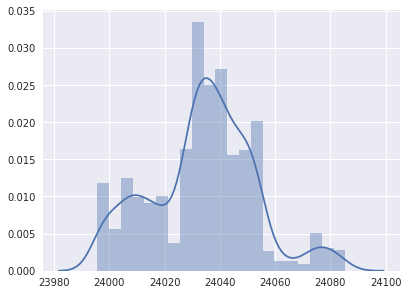

In [14]:
/%python
sns.distplot(var1)
plt.show()

Let's use pyplot to visualize a day's worth of data to identify possible trends.

In [15]:
//We'll still use q to pull the data
r:(),/:{exec rn from select rn:(reading-min(reading))%(max(reading)-min(reading)) from x16 where date=2016.07.20,sym=x}'[c]
.p.set[`rp;r]
.p.set[`c;c]

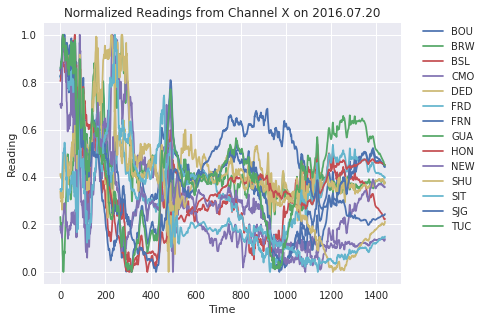

In [16]:
/%python
t = list(range(1440))
for i in range(len(rp)):
    plt.plot(t,np.transpose(rp[i]),label=c[i])
plt.xlabel('Time')
plt.ylabel('Reading')
plt.title('Normalized Readings from Channel X on 2016.07.20')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.show()

I can also use a wrapper for matplotlib.pyplot written in q which lets us use pyplot methods and functions like q functions.

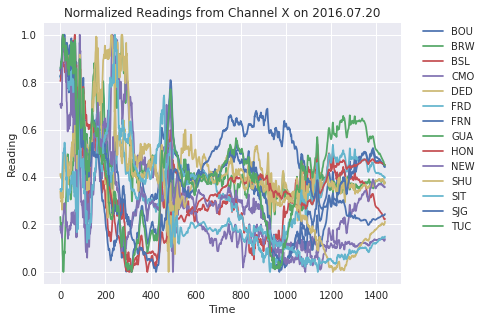

In [17]:
\l /data/jupyterq/importmatplotlib.q
t:til 1440
plt:.matplotlib.pyplot[]
{plt.plot[t;raze x]}'[r];
plt.xlabel"Time";
plt.ylabel"Reading";
plt.title"Normalized Readings from Channel X on 2016.07.20";
/plt.legend[string c;pykwargs`bbox_to_anchor`loc`borderaxespad!(1.05 1;2;0.)];
plt.legend[string c;`bbox_to_anchor pykw(1.05 1);`loc pykw 2;`borderaxespad pykw 0.];
plt.show[];

Since this is indeed data based on location, we can get the georgraphical position of each data center and create geographical plots (this can be found on the geomags link from above).

In [18]:
c:`BOU`BRW`BSL`CMO`DED`FRD`FRN`GUA`HON`NEW`SHU`SIT`SJG`TUC
refData:c!(("Boulder";40.137;-105.237);("Barrow";71.322;-156.622);("Stennis Space Center";30.350;-89.635);("College";64.874;-147.86);("Deadhorse";70.355;-148.793);("Fredericksburg";38.205;-77.373);("Fresno";37.091;-119.718);("Guam";13.588;144.867);("Honolulu";21.316;-158);("Newport";48.265;-117.122);("Shumagin";55.348;-160.462);("Sitka";57.058;-135.325);("San Juan";18.113;-66.151);("Tucson";32.174;-110.733))
refData

BOU| "Boulder"              40.137 -105.237
BRW| "Barrow"               71.322 -156.622
BSL| "Stennis Space Center" 30.35  -89.635 
CMO| "College"              64.874 -147.86 
DED| "Deadhorse"            70.355 -148.793
FRD| "Fredericksburg"       38.205 -77.373 
FRN| "Fresno"               37.091 -119.718
GUA| "Guam"                 13.588 144.867 
HON| "Honolulu"             21.316 -158    
NEW| "Newport"              48.265 -117.122
SHU| "Shumagin"             55.348 -160.462
SIT| "Sitka"                57.058 -135.325
SJG| "San Juan"             18.113 -66.151 
TUC| "Tucson"               32.174 -110.733


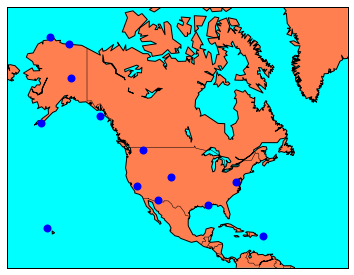

In [20]:
p)map = Basemap(projection='merc',llcrnrlat=5,urcrnrlat=75,llcrnrlon=-175,urcrnrlon=-30,lat_ts=20)
p)map.drawcoastlines()
p)map.drawcountries()
p)map.fillcontinents(color='coral',lake_color='aqua')
p)map.drawmapboundary(fill_color='aqua')
.p.set[`lons;(value refData)[;2]]
.p.set[`lats;(value refData)[;1]]
p)x,y = map(lons,lats)
p)map.plot(x,y,'bo',markersize=8)
p)plt.show()

In [21]:
/Define a function that given a date and channel as an input, will return the maximum reading for that day and for each data center plot it in a map
readingByDay:{if[2016<>`year$y;'"Input date must be in the year 2016."];.d.t:?[x;enlist(=;`date;y);(enlist `sym)!enlist `sym;(enlist `reading)!enlist(max;`reading)]}

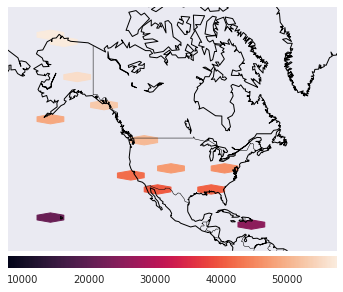

In [22]:
readingByDay[`z16;2016.05.02]
.p.set[`c;exec reading from .d.t]
p)c.tolist()
p)map = Basemap(projection='merc',llcrnrlat=5,urcrnrlat=75,llcrnrlon=-180,urcrnrlon=-30,lat_ts=20)
p)map.drawcoastlines()
p)map.drawcountries()
p)x,y = map(lons,lats)
p)map.hexbin(np.array(x),np.array(y),gridsize=25,C=c)
p)map.colorbar(location='bottom')
p)plt.show()